In [54]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


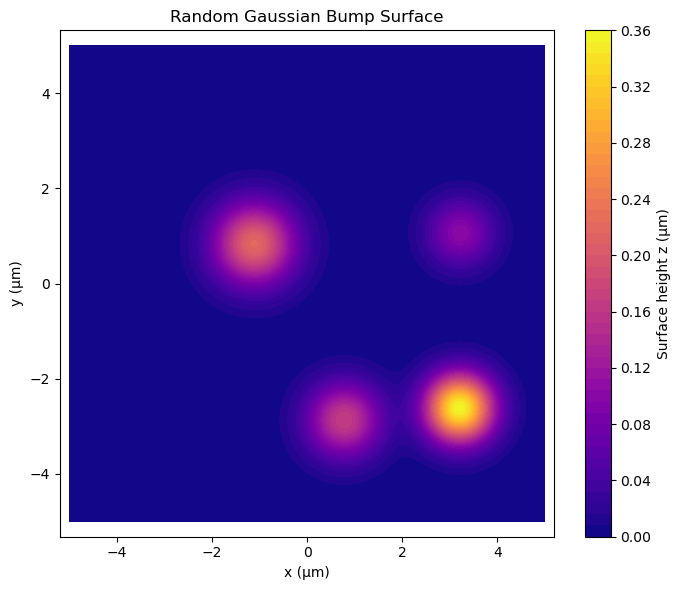

In [55]:
# Re-run and add CSV export of bump parameters

# Grid for surface
x = np.linspace(-5, 5, 200)
y = np.linspace(-5, 5, 200)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

np.random.seed(4)  # for reproducibility

# Generate random bump parameters
num_bumps = np.random.randint(2, 5)
bump_data = []

for i in range(num_bumps):
    x0 = np.random.uniform(-4, 4)
    y0 = np.random.uniform(-4, 4)
    height = np.random.uniform(0.1, 0.4)
    sigma = np.random.uniform(0.2, 0.7)

    bump = height * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
    Z += bump

    bump_data.append({
        "bump_id": i,
        "x0": x0,
        "y0": y0,
        "height": height,
        "sigma": sigma
    })

# Optional base level (like a flat substrate)
Z -= 0

# Export bump parameters to CSV
bump_df = pd.DataFrame(bump_data)
csv_path = "/mnt/c/Users/tripl/OneDrive - Danmarks Tekniske Universitet/Speciale/bioscat3d/MeepTests/dataDump.csv"  # Provide download path
bump_df.to_csv(csv_path, index=False)

# Plot the surface
plt.figure(figsize=(7, 6))
contour = plt.contourf(X, Y, Z, levels=50, cmap='plasma')
plt.colorbar(contour, label="Surface height z (μm)")
plt.title("Random Gaussian Bump Surface")
plt.xlabel("x (μm)")
plt.ylabel("y (μm)")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [56]:
import numpy as np
import matplotlib.pyplot as plt

# --- Compute curvature at the peak ---
# Step 1: Find index of highest point
peak_idx = np.unravel_index(np.argmax(Z), Z.shape)
i, j = peak_idx

# Step 2: Compute second derivatives
dz_dx2 = np.gradient(np.gradient(Z, x, axis=1), x, axis=1)  # ∂²Z/∂x²
dz_dy2 = np.gradient(np.gradient(Z, y, axis=0), y, axis=0)  # ∂²Z/∂y²

# Step 3: Approximate mean curvature at the peak
curvature = 0.5 * (dz_dx2[i, j] + dz_dy2[i, j])

r = 1 / abs(curvature) if curvature != 0 else np.inf

# Step 4: Compute d
d = 0.14*r

# Safety check
if d <= 0:
    raise ValueError(f"Computed d = {d:.4f} is non-positive. Consider adjusting curvature method or bump parameters.")

print(f"Peak curvature: {curvature:.6f} μm⁻¹")
print(f"Radius of curvature: r = {r:.6f} μm")
print(f"Final offset d = {d:.6f} μm")


def generate_surface_and_points(lambda_0=0.325, d = 0.1, seed=4):
    # --- Step 1: Create surface ---
    x = np.linspace(-5, 5, 200)
    y = np.linspace(-5, 5, 200)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros_like(X)

    np.random.seed(seed)

    # Gaussian bumps
    num_bumps = np.random.randint(2, 5)
    for _ in range(num_bumps):
        x0 = np.random.uniform(-4, 4)
        y0 = np.random.uniform(-4, 4)
        height = np.random.uniform(0.1, 0.4)
        sigma = np.random.uniform(0.2, 0.7)
        bump = height * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))
        Z += bump

    # --- Step 2: Test point count ---
    Lx = x[-1] - x[0]
    Ly = y[-1] - y[0]
    N_test = int(np.ceil(50 * (Lx * Ly) / lambda_0**2))

    # --- Step 3: Flatten grid and remove edge points ---
    X_flat, Y_flat, Z_flat = X.ravel(), Y.ravel(), Z.ravel()
    points = np.stack([X_flat, Y_flat, Z_flat], axis=1)
    mask = (X_flat > x[0]) & (X_flat < x[-1]) & (Y_flat > y[0]) & (Y_flat < y[-1])
    interior_points = points[mask]

    total_pts = interior_points.shape[0]
    N_test = min(N_test, total_pts)

    # --- Step 4: Sample test points ---
    idx_test = np.arange(0, total_pts, 2)  # ✅ every second point in order
    test_points = interior_points[idx_test] # ✅ preserves structure

    # After selecting test_points
    N_test = len(test_points)  # ✅ actual number used

    # For aux indices
    aux_test_indices = np.arange(0, N_test, 2)  # ✅ safe indexing

    # --- Step 5: Compute normals and tangents ---
    dz_dx, dz_dy = np.gradient(Z, x, y)
    dz_dx_flat = dz_dx.ravel()[mask]
    dz_dy_flat = dz_dy.ravel()[mask]

    normals = np.stack([-dz_dx_flat, -dz_dy_flat, np.ones_like(dz_dx_flat)], axis=1)
    normals /= np.linalg.norm(normals, axis=1, keepdims=True)
    test_normals = normals[idx_test]

    # Compute tangent vectors (Gram-Schmidt)
    tangent1 = np.zeros_like(test_normals)
    tangent2 = np.zeros_like(test_normals)

    for i, n in enumerate(test_normals):
        if abs(n[2]) < 0.9:
            ref = np.array([0, 0, 1])
        else:
            ref = np.array([1, 0, 0])

        t1 = ref - np.dot(ref, n) * n
        t1 /= np.linalg.norm(t1)
        t2 = np.cross(n, t1)

        tangent1[i] = t1
        tangent2[i] = t2

    # --- Step 6: Compute auxiliary points and mapping indices ---
    aux_test_indices = np.arange(N_test)[::2]
    aux_test_points = test_points[aux_test_indices]
    aux_test_normals = test_normals[aux_test_indices]

    aux_points_int = aux_test_points + d * aux_test_normals
    aux_points_ext = aux_test_points - d * aux_test_normals

    # --- Return full structured data ---
    return {
    "test_points": test_points,
    "test_normals": test_normals,
    "tangent1": tangent1,
    "tangent2": tangent2,
    "aux_points_int": aux_points_int,
    "aux_points_ext": aux_points_ext,
    "aux_indices": aux_test_indices,
    "bump_data": bump_data  # ✅ this is the key you need
    }


# Usage
data = generate_surface_and_points(d = 0.14*r)

# Access results
test_pts = data["test_points"]
normals = data["test_normals"]
t1 = data["tangent1"]
t2 = data["tangent2"]
aux_int = data["aux_points_int"]
aux_ext = data["aux_points_ext"]
aux_test_idx = data["aux_indices"]


Peak curvature: -1.384015 μm⁻¹
Radius of curvature: r = 0.722536 μm
Final offset d = 0.101155 μm


In [57]:
import pandas as pd

def export_to_csv(data, base_path=""):
    # --- Export test points with normals and tangents ---
    df_test = pd.DataFrame({
        "x": data["test_points"][:, 0],
        "y": data["test_points"][:, 1],
        "z": data["test_points"][:, 2],
        "nx": data["test_normals"][:, 0],
        "ny": data["test_normals"][:, 1],
        "nz": data["test_normals"][:, 2],
        "t1x": data["tangent1"][:, 0],
        "t1y": data["tangent1"][:, 1],
        "t1z": data["tangent1"][:, 2],
        "t2x": data["tangent2"][:, 0],
        "t2y": data["tangent2"][:, 1],
        "t2z": data["tangent2"][:, 2]
    })
    df_test.to_csv(base_path + "test_points.csv", index=False)

    # --- Export auxiliary points with matching test point index ---
    aux_idx = data["aux_indices"]

    df_aux = pd.DataFrame({
        "type": ["int"] * len(aux_idx) + ["ext"] * len(aux_idx),
        "x": np.concatenate([data["aux_points_int"][:, 0], data["aux_points_ext"][:, 0]]),
        "y": np.concatenate([data["aux_points_int"][:, 1], data["aux_points_ext"][:, 1]]),
        "z": np.concatenate([data["aux_points_int"][:, 2], data["aux_points_ext"][:, 2]]),
        "test_index": np.concatenate([aux_idx, aux_idx])
    })
    df_aux.to_csv(base_path + "aux_points.csv", index=False)

    print("✅ Data exported to test_points.csv and aux_points.csv")

# Call it after generating
export_to_csv(data)


✅ Data exported to test_points.csv and aux_points.csv


In [58]:
import plotly.graph_objects as go
import numpy as np

# Run this first if not done already
data = generate_surface_and_points(d = 0.14*r)

# Now extract surface data for plotting
X, Y = np.meshgrid(np.linspace(-5, 5, 200), np.linspace(-5, 5, 200))
Z = np.zeros_like(X)

# Reconstruct surface using stored bump_data
for bump in data["bump_data"]:
    x0, y0, height, sigma = bump["x0"], bump["y0"], bump["height"], bump["sigma"]
    Z += height * np.exp(-((X - x0)**2 + (Y - y0)**2) / (2 * sigma**2))

# Create Plotly figure
fig = go.Figure()

# Add surface
fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.6))

# Add test and auxiliary points
fig.add_trace(go.Scatter3d(
    x=data["test_points"][:, 0],
    y=data["test_points"][:, 1],
    z=data["test_points"][:, 2],
    mode='markers',
    marker=dict(size=2, color='red'),
    name="Test points"
))
fig.add_trace(go.Scatter3d(
    x=data["aux_points_int"][:, 0],
    y=data["aux_points_int"][:, 1],
    z=data["aux_points_int"][:, 2],
    mode='markers',
    marker=dict(size=2, color='orange'),
    name="Aux (int)"
))
fig.add_trace(go.Scatter3d(
    x=data["aux_points_ext"][:, 0],
    y=data["aux_points_ext"][:, 1],
    z=data["aux_points_ext"][:, 2],
    mode='markers',
    marker=dict(size=2, color='cyan'),
    name="Aux (ext)"
))

# Layout settings
fig.update_layout(
    scene=dict(
        xaxis_title='x (μm)',
        yaxis_title='y (μm)',
        zaxis_title='z (μm)',
        aspectmode='data'  # ✅ makes the axes scale equally
    ),
    title="Interactive 3D Surface with Points"
)


# Save to HTML
fig.write_html("surface_with_points.html")
print("✅ Plot saved to 'surface_with_points.html'. Open it in your browser.")


✅ Plot saved to 'surface_with_points.html'. Open it in your browser.


In [59]:
# Helper function to make and save a plot
def save_surface_plot(points, color, name, filename):
    fig = go.Figure()

    # Add surface
    fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.6))

    # Add selected point type
    fig.add_trace(go.Scatter3d(
        x=points[:, 0],
        y=points[:, 1],
        z=points[:, 2],
        mode='markers',
        marker=dict(size=2, color=color),
        name=name
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='x (μm)',
            yaxis_title='y (μm)',
            zaxis_title='z (μm)',
            aspectmode='data'
        ),
        title=f"3D Surface with {name}"
    )

    fig.write_html(filename)
    print(f"✅ Saved: {filename}")

# Save individual plots
save_surface_plot(data["test_points"], 'red', "Test Points", "surface_test_points.html")
save_surface_plot(data["aux_points_int"], 'orange', "Auxiliary Interior Points", "surface_aux_int.html")
save_surface_plot(data["aux_points_ext"], 'cyan', "Auxiliary Exterior Points", "surface_aux_ext.html")


✅ Saved: surface_test_points.html
✅ Saved: surface_aux_int.html
✅ Saved: surface_aux_ext.html


In [60]:
# Identify test points with associated auxiliary points
mask_with_aux = np.zeros(len(data["test_points"]), dtype=bool)
mask_with_aux[data["aux_indices"]] = True

# Split the test points
test_with_aux = data["test_points"][mask_with_aux]
test_without_aux = data["test_points"][~mask_with_aux]

# Plot them separately
fig = go.Figure()

# Add surface
fig.add_trace(go.Surface(z=Z, x=X, y=Y, colorscale='Viridis', opacity=0.6))

# Test points with aux
fig.add_trace(go.Scatter3d(
    x=test_with_aux[:, 0],
    y=test_with_aux[:, 1],
    z=test_with_aux[:, 2],
    mode='markers',
    marker=dict(size=3, color='blue'),
    name="Test points with aux"
))

# Test points without aux
fig.add_trace(go.Scatter3d(
    x=test_without_aux[:, 0],
    y=test_without_aux[:, 1],
    z=test_without_aux[:, 2],
    mode='markers',
    marker=dict(size=2, color='gray'),
    name="Other test points"
))

fig.update_layout(
    scene=dict(
        xaxis_title='x (μm)',
        yaxis_title='y (μm)',
        zaxis_title='z (μm)',
        aspectmode='data'
    ),
    title="Test Points With vs Without Aux Points"
)

fig.write_html("test_points_with_vs_without_aux.html")
print("✅ Saved: test_points_with_vs_without_aux.html")


✅ Saved: test_points_with_vs_without_aux.html
